# 계층적 멀티 에이전트
https://github.com/aritrasen87/LLM_RAG_Model_Deployment/blob/main/langgraph_supervisor.ipynb

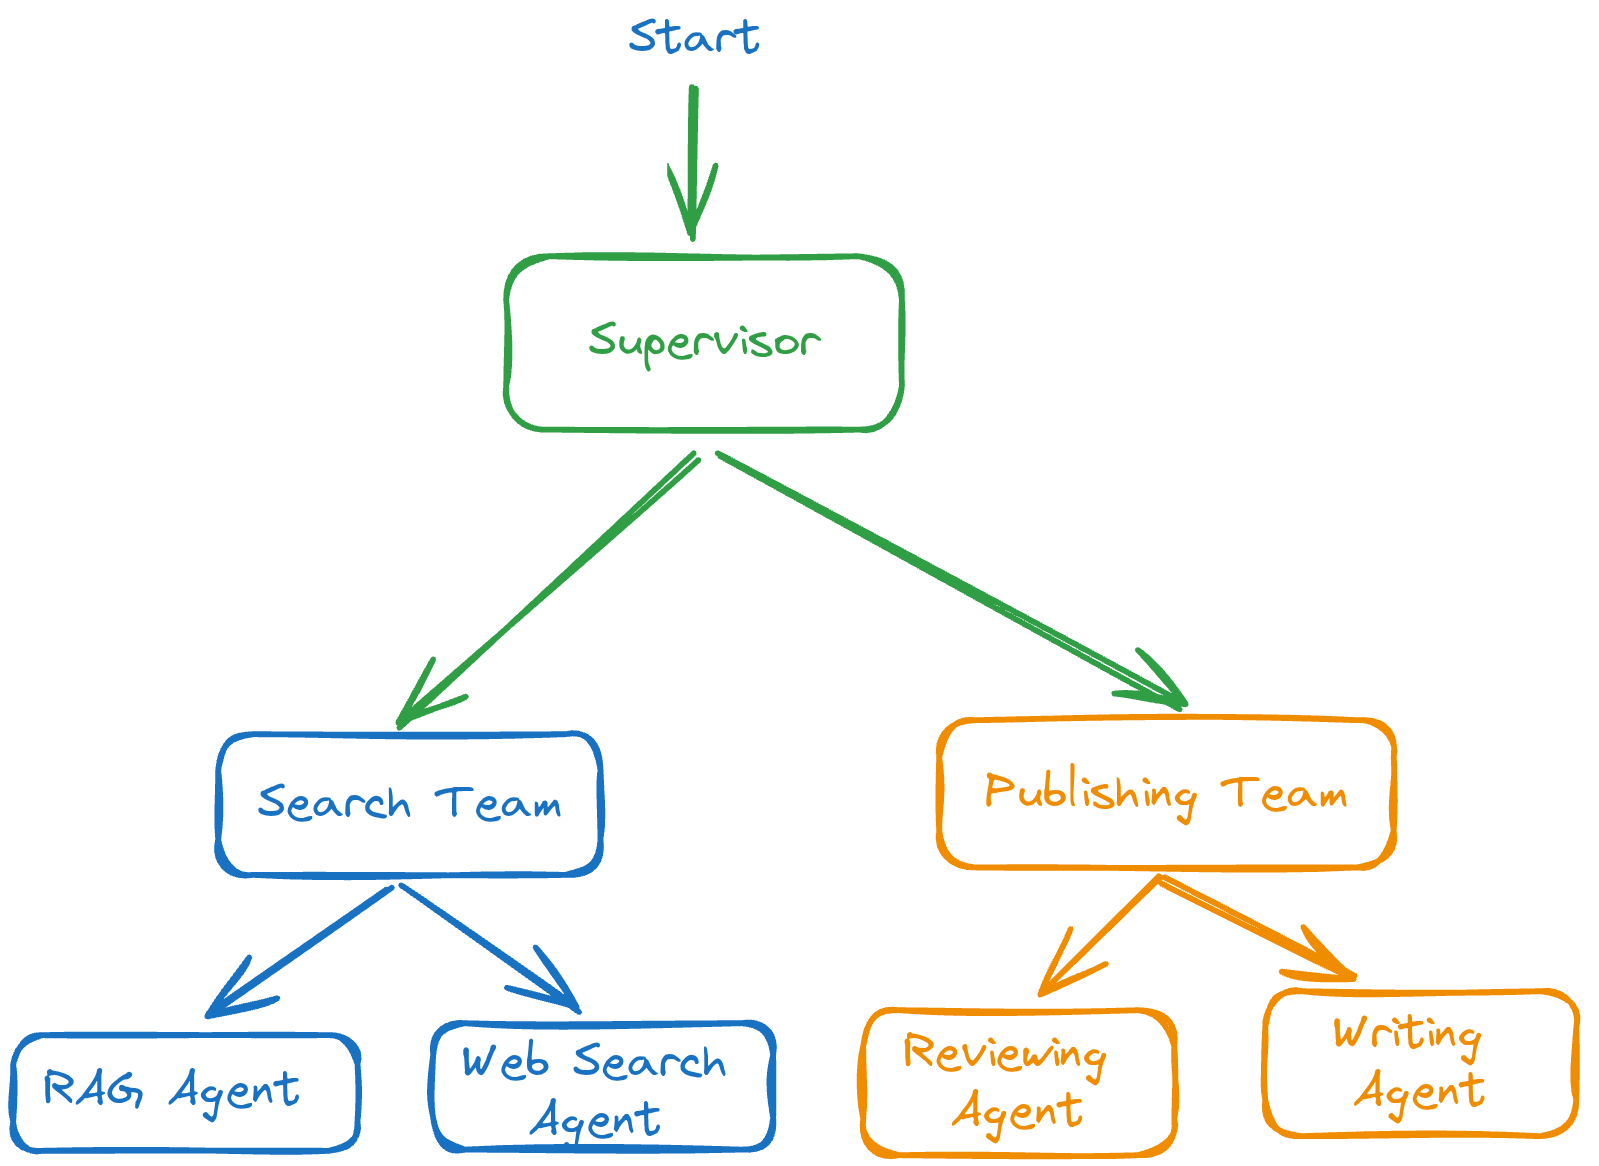

In [4]:
%pip install -qU langchain langchain-community sentence-transformers datasets chromadb

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import datasets
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.docstore.document import Document


knowledge_base = datasets.load_dataset("m-ric/huggingface_doc", split="train")
knowledge_base = knowledge_base.filter(lambda row: row["source"].startswith("huggingface/transformers"))

source_docs = [
    Document(page_content=doc["text"], metadata={"source": doc["source"].split("/")[1]})
    for doc in knowledge_base
]

### Creating Chunks using RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    add_start_index=True,
    strip_whitespace=True,
    separators=["\n\n", "\n", ".", " ", ""],
)
new_docs = text_splitter.split_documents(documents=source_docs)

###  BGE Embddings

from langchain_community.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cuda"}
encode_kwargs = {"normalize_embeddings": True}
embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)
### Populate Vector DB

db = Chroma.from_documents(new_docs, embeddings)

In [ ]:
def rag_search(query:str):
    "Function to do RAG search"
    retriever = db.as_retriever(search_kwargs={"k": 4})
    docs = retriever.invoke(
            query,
        )
    return "\nRetrieved documents:\n" + "".join(
        [
            f"\n\n===== Document {str(i)} =====\n" + doc.page_content
            for i, doc in enumerate(docs)
        ]
    )

In [ ]:
rag_agent = create_react_agent(
    model=model,
    tools=[rag_search],
    name="rag_expert",
    prompt="You are a RAG tool with access to transformer related documents."
)

## Search Team = RAG Agent + Research Agent

In [ ]:
search_team = create_supervisor(
    [research_agent, rag_agent],
    model=model,
    prompt=(
        "You are a team supervisor managing a web search expert and a RAG search expert. "
        "For current events and information, use research_agent."
        "For transformer related information , use rag_agent."
    )
).compile(name="search_team")

In [ ]:
def review_content(input:str):
    "Reviews the content"
    prompt = f"review the given content {input} , make necessary corrections and rewrite in a positive tone "
    return model.invoke(prompt)

reviewing_agent = create_react_agent(
    model=model,
    tools=[review_content], # tools to help reviewing
    name="reviewing_expert",
    prompt="You are a world class reviewing expert. Don't use this tool to write the final output"
)

In [ ]:
def writer(text_to_dump:str):
    "Writes in txt file"
    with open("final.txt", "w") as f:
        f.write(text_to_dump)
    print("Text has been written to final.txt")

writing_agent = create_react_agent(
    model=model,
    tools=[writer],
    name="writing_expert",
    prompt="You are a world class writing expert. Your job is write the final content in a text file"
)


## Publishing Team = Reviewing Agent + Writing Agent

In [ ]:
publishing_team = create_supervisor(
    [reviewing_agent , writing_agent],
    model=model,
    prompt=(
        "You are a team supervisor managing a reviewing expert and a writing expert. "
        "For making correction in the content, use reviewing_agent."
        "For writing final content in a text file ,make sure you only use writing_agent."
    )
).compile(name="publishing_team")

In [ ]:
top_level_supervisor = create_supervisor(
    [search_team, publishing_team],
    model=model,
    prompt=("you are a top level supervisor managing a search team and publishing team."
            "For recent events and information, use search_team."
            "For reviewing and writing final content in a text file , use publishing_team."
            "Always do handoff to the publishing_team and Use writing_agent in the publishing_team to write into a text file"
    ),
    output_mode="full_history" #output_mode="last_message" during handover
).compile(name="top_level_supervisor")

In [ ]:
from IPython.display import Image

display(Image(top_level_supervisor.get_graph().draw_mermaid_png()))

In [ ]:
result = top_level_supervisor.invoke({
    "messages": [
        {
            "role": "user",
            "content": "Tell me the role of Q,K,V matrixes in transfromer archietecture , review the content and then write into a text file."
        }
    ]
})

In [ ]:
for m in result['messages']:
    m.pretty_print()